In [ ]:

import numpy as np
import matplotlib
from matplotlib.patches import Circle
from matplotlib import interactive
from scipy.spatial.transform import Rotation

class Obstacle:
    def __init__(self,radius,location,risk):
        """[summary]
        Args:
            dimenesion ([type]): '2' or '3' [description]
            radius ([type]): [description]
            location ([type]): [description]
            risk ([type]): [description]
        """
        self.radius = radius
        self.risk = risk
        self.state = np.array([location[0],location[1],location[2],0,0,0])
        self.gpc_state = np.zeros(13)
        self.gpc_state[0] = location[0]
        self.gpc_state[1] = location[1]
        self.gpc_state[2] = location[2]


In [ ]:
print(matplotlib.get_backend())


module://matplotlib_inline.backend_inline


In [ ]:
'''
Description : Class that describes the Map for motion planning
'''



class Map(Obstacle):
    def __init__(self,obstacle_list,map_setup,robot_setup):
        """[summary]

        Args:
            state_init ([type]): [description]
            state_final ([type]): [description]
            obstacle_list ([type]): [description]
        """
        self.lower_limit = map_setup["lower_limit"]
        self.upper_limit = map_setup["upper_limit"]
        self.obstacle_list = obstacle_list
        self.dimension = '3'

        self.initial_state = robot_setup["initial_state"]
        self.initial_state_covariance = robot_setup["initial_state_covariance"]
        self.terminal_state = robot_setup["terminal_state"]
        self.terminal_state_covariance = robot_setup["terminal_state_covariance"]



In [ ]:

import cvxpy as cp
import numpy as np

import jax.numpy as onp
# plotting
import matplotlib.pyplot as mpl

class SCP():
    def __init__(self,Robot,Map,initialization):

        self.Robot = Robot
        self.Map = Map

        self.dyn = Robot.dyn
        self.A = Robot.A
        self.B = Robot.B

        self.dt = Robot.dt

        self.num_states = Robot.num_states
        self.num_control = Robot.num_control

        self.u_max = Robot.u_max
        self.u_min = Robot.u_min

        self.lower_limit = Robot.lower_limit
        self.upper_limit = Robot.upper_limit

        self.radius = 0

        self.initial_state = Map.initial_state
        self.terminal_state = Map.terminal_state
        self.obstacle_list = Map.obstacle_list
        self.num_obstacles = len(self.obstacle_list)

        self.state_min = np.concatenate((Map.lower_limit,Robot.lower_limit))
        self.state_max = np.concatenate((Map.upper_limit,Robot.upper_limit))


        self.initialization = initialization
        self.nominal_trajectory = {}
        self.nominal_trajectory["valid"] = self.initialization["valid"]
        if self.nominal_trajectory["valid"] == True:
            self.nominal_trajectory["state"] = self.initialization["state"]
            self.nominal_trajectory["control"] = self.initialization["control"]
            self.num_tsteps = self.nominal_trajectory["state"].shape[0]
        # print(self.num_tsteps)
        else:
            self.num_tsteps = self.Robot.num_tsteps
            self.nominal_trajectory["state"] = np.linspace(self.initial_state,self.terminal_state,self.num_tsteps)
            #print('self.nominal_trajec', self.nominal_trajectory["state"])
            self.nominal_trajectory["control"] = 0.01*np.ones([int(self.num_tsteps-1),self.num_control])
            #print('self.nom_control',self.nominal_trajectory["control"])

        self.sol= {}
        self.sol["state"] = []
        self.sol["control"] = []
        self.sol["dt"] = self.Robot.dt


        self.trust = {"x":10000,"u":10000} #can be increased to 1000
        self.scp_param = {}
        self.scp_param['error_tolerance'] = 0.01
        self.scp_param['alpha'] = 1.1
        self.scp_param['beta'] = 0.9  # <1 learning rate
        self.scp_param['iter_max'] = 10


    def scp(self):
        error = 1
        iterat = 1
        xprev = self.nominal_trajectory["state"]
        uprev = self.nominal_trajectory["control"]
        while iterat <= self.scp_param["iter_max"] and error >= self.scp_param["error_tolerance"]:
            # print('xprev:',xprev[:,1])
            result = self.convex_program(xprev,uprev)
            if result == 'INCREASE_TRUST':
                self.trust['x'] = self.trust['x']*self.scp_param["alpha"]
                self.trust['u'] = self.trust['u']*self.scp_param["alpha"]
                print('Exception Occured, Increasing Trust to :',self.trust['x'])
                continue
            else:
                x_sol = result[0]
                u_sol = result[1]
                iterat = iterat +1
                self.trust['x'] = self.trust['x']*self.scp_param["beta"]
                self.trust['u'] = self.trust['u']*self.scp_param["beta"]
                print(type(xprev),type(x_sol))

                error =  np.amax(np.linalg.norm(x_sol-xprev,axis=1))
                print('iter :',iterat,'error :', error)
                # update previous and nominal trajectory
                xprev = x_sol
                uprev = u_sol
                # print('x shape:',x_sol.shape[0])
                # print('x:',x_sol[:,0])
                # print('y:',x_sol[:,1])

        self.sol["state"] = xprev
        self.sol["control"] = uprev
        print("SCP Converged!, Access solution using self.sol")
        return 1

    def collision_constraint_3d(self,radius,obstacle_state,Xprev):
        mean = Xprev.reshape((self.num_states,1))
        G = np.zeros((self.num_states,self.num_states)) # matrix to  pulling out position
        G[0,0] = 1
        G[1,1] = 1
        G[2,2] = 1
        mean_position = (np.mat(G)*np.mat(mean)).reshape((self.num_states))
        #print(mean_position)
        collision_dist = obstacle_state.reshape((self.num_states)) - mean_position
        #print(obstacle_state)
        #print(mean_position)
        a = collision_dist.reshape((self.num_states,1))
        #print(a)
        b =  np.mat(-a.reshape((1,self.num_states)))*np.mat(obstacle_state.reshape((self.num_states,1))) \
            + radius*np.linalg.norm(collision_dist,2)
        #print(b)
        return np.array(a,dtype=float), np.array(b,dtype=float)


    def convex_program(self,xprev,uprev):
        X = cp.Variable((self.num_tsteps,self.num_states))
        U = cp.Variable((self.num_tsteps-1,self.num_control))
        terminal_slack = cp.Variable(1)
        ## Initial Condition
        constraint = []
        print('init',self.initial_state)
        print(type(self.initial_state))

        constraint.append(X[0] == cp.Constant(self.initial_state))

        ## Terminal Condition
        constraint.append(cp.norm(X[self.num_tsteps-1] - self.terminal_state)<=terminal_slack)
        print('term',self.terminal_state)
        ## Obstacles
        for t in range(self.num_tsteps-1):
            for jj in range(self.num_obstacles):
                # print(self.num_obstacles)
                a1, b1 = self.collision_constraint_3d(radius=self.obstacle_list[jj].radius + self.radius,\
                    obstacle_state=self.obstacle_list[jj].gpc_state,Xprev=xprev[t])
              #  a1, b1 = self.Map.obstacle_list[jj].stationary_collision_constraint(xprev[jj]) #uncommented
                constraint.append(a1.T@X[t]+np.reshape(b1,1)<=0)

        ## Dynamics
        for t in range(self.num_tsteps-1):
            x_dummy = onp.array(xprev[t],dtype=np.float32)
            u_dummy = onp.array(uprev[t],dtype=np.float32)
            Aa = self.A(x_dummy,u_dummy,self.dt)
            Ba = self.B(x_dummy,u_dummy,self.dt)
            Ca =  self.dyn(x_dummy,u_dummy,self.dt)- Aa@x_dummy- Ba@u_dummy
            constraint.append(X[t+1]== X[t]+ Aa@X[t] + Ba@U[t] + Ca) #

        # constraint on angular rotation
        for t in range(self.num_tsteps-1):
            for i in range(self.num_states):
                constraint.append(X[t,i]<=self.state_max[i])
                constraint.append(X[t,i]>=self.state_min[i])

        # State trust region
        for t in range(self.num_tsteps):
            constraint.append(cp.norm(X[t,:] - xprev[t,:] ) <= self.trust['x'])

        # Control trust region
        for t in range(self.num_tsteps-1):
            constraint.append(cp.norm(U[t,:] - uprev[t,:] ) <= self.trust['u'])


        # control constraints
        for t in range(self.num_tsteps-1):
            constraint.append(U[t]<=self.u_max)
            constraint.append(U[t]>=self.u_min)

        cost = 1e3*terminal_slack
        cost += cp.sum_squares(U-uprev)*self.dt
        for t in range(self.num_tsteps-1):
            cost += cp.quad_form(U[t],np.eye(self.num_control))*self.dt #cp.norm2(U[t])*dt
        #print('constraint', constraint)
        # terminal state cost
        #cost += 1e3*cp.quad_form(X[self.num_tsteps-1]-self.terminal_state,np.eye(self.num_states))
        #print('cost',cost)
        print('constraint',constraint)
        problem = cp.Problem(cp.Minimize(cost),constraint)


        try:

            result = problem.solve(solver='ECOS')
            print('result',result)
        except:
            return 'INCREASE_TRUST'
        # Xv = np.around(X.value,decimals = 5)
        # Uv = np.around(U.value,decimals = 5)
        #print('X.vl, U.vl', X.value, U.value)
        return [X.value,U.value]

In [ ]:

from jax import jit, jacfwd

class Robot():
    def __init__(self,time_param,dynamics) -> None:
        self.dyn = jit(dynamics)
        self.radius = 0
        self.num_states = 13
        self.num_control = 6

        self.dt = time_param["dt"]
        self.num_tsteps = time_param["num_tsteps"]

        self.upper_limit = 10000*np.array([1.0,1.0,1.0,\
               1.,1.,1.,1.,\
                    1.0,1.0,1.0])
        self.lower_limit = np.negative(self.upper_limit)

        self.u_max = 5000*np.array([1,1,1,\
              0.3,0.3,0.3])
        self.u_min = np.negative(self.u_max)

        self.A = jit(jacfwd(self.dyn,0))
        self.B = jit(jacfwd(self.dyn,1))

        pass

In [ ]:
import jax.numpy as np2
import jax

def free_flyer(state,control,dt):
	m = 7.2
	J1 = 0.07
	J2 = 0.07
	J3 = 0.17

# control variables
	u1=control[0]
	u2=control[1]
	u3=control[2]
	u4=control[3]
	u5=control[4]
	u6=control[5]

# state variables
	x00=state[0]
	x10=state[1]
	x20=state[2]
	x30=state[3]
	x40=state[4]
	x50=state[5]
	x60=state[6]
	x70=state[7]
	x80=state[8]
	x90=state[9]
	x100=state[10]
	x110=state[11]
	x120=state[12]
# writing dynamics
	dxdt = np2.zeros(13)
	dxdt = np2.array(dxdt,dtype = np.float32)
	xx = dt*x30
	dxdt = dxdt.at[0].set(xx)
	xx = dt*x40
	dxdt = dxdt.at[1].set(xx)
	xx = dt*x50
	dxdt = dxdt.at[2].set(xx)
	xx = 1.0*dt*u1/m
	dxdt = dxdt.at[3].set(xx)
	xx = 1.0*dt*u2/m
	dxdt = dxdt.at[4].set(xx)
	xx = 1.0*dt*u3/m
	dxdt = dxdt.at[5].set(xx)
	xx = dt*(-0.5*x100*x70 - 0.5*x110*x80 - 0.5*x120*x90)
	dxdt = dxdt.at[6].set(xx)
	xx = dt*(0.5*x100*x60 - 0.5*x110*x90 + 0.5*x120*x70)
	dxdt = dxdt.at[7].set(xx)
	xx = dt*(0.5*x100*x90 + 0.5*x110*x60 - 0.5*x120*x70)
	dxdt = dxdt.at[8].set(xx)
	xx = dt*(-0.5*x100*x80 + 0.5*x110*x70 + 0.5*x120*x60)
	dxdt = dxdt.at[9].set(xx)
	xx = -J2*dt*x110*x120/J1 + J3*dt*x110*x120/J1 + dt*u4/J1
	dxdt = dxdt.at[10].set(xx)
	xx = -J1*dt*x100*x120/J2 + J3*dt*x100*x120/J2 + dt*u5/J2
	dxdt = dxdt.at[11].set(xx)
	xx = J1*dt*x100*x110/J3 - J2*dt*x100*x110/J3 + dt*u6/J3
	dxdt = dxdt.at[12].set(xx)
	return dxdt

In [ ]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as mpl
#from src.Map.Obstacle import Obstacle
num_states = 13
num_uncertainty = 13+4
num_gpcpoly = 5
polynomial_degree = 1

##  ---- cluttered 3d space
obstacle_list = []
radius = 0.3
location = np.array([-0.5,-0.5,0.5,0,0,0,0])
risk = 0.05
obstacle_list.append(Obstacle(radius=radius,\
        location=location,\
            risk = risk))


radius = 0.2
location = np.array([0.5,0.3,0.5,0,0,0])
risk = 0.05
obstacle_list.append(Obstacle(radius=radius,\
        location=location,\
            risk = risk))


radius = 0.3
location = np.array([0.5,-0.5,0.5,0,0,0])
risk = 0.05
obstacle_list.append(Obstacle(radius=radius,\
        location=location,\
            risk = risk))

radius = 0.15
location = np.array([-0.5,0.5,0.5,0,0,0])
risk = 0.05
obstacle_list.append(Obstacle(radius=radius,\
        location=location,\
            risk = risk))

radius = 0.1
location = np.array([-0.5,-0.5,-0.5,0,0,0,0])
risk = 0.05
obstacle_list.append(Obstacle(radius=radius,\
        location=location,\
            risk = risk))


radius = 0.2
location = np.array([0.5,0.5,-0.5,0,0,0])
risk = 0.05
obstacle_list.append(Obstacle(radius=radius,\
        location=location,\
            risk = risk))


radius = 0.3
location = np.array([0.5,-0.5,-0.5,0,0,0])
risk = 0.05
obstacle_list.append(Obstacle(radius=radius,\
        location=location,\
            risk = risk))

radius = 0.15
location = np.array([-0.5,0.5,-0.5,0,0,0])
risk = 0.05
obstacle_list.append(Obstacle(radius=radius,\
        location=location,\
            risk = risk))

radius = 0.15
location = np.array([-0.2,0.2,0.0,0,0,0])
risk = 0.05
obstacle_list.append(Obstacle(radius=radius,\
        location=location,\
            risk = risk))

def plot_sphere(ax,radius,location):
    u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
    x = location[0] + radius*np.cos(u) * np.sin(v)
    y = location[1] + radius*np.sin(u) * np.sin(v)
    z = location[2] + radius*np.cos(v)
    return ax.plot_surface(x, y, z, color='r',alpha = 0.3)


if __name__=="__main__":
    print("")

In [1]:
#pure planner

from time import time

# map
#from Map import Map
#from Obstacle import Obstacle


#from SCP import SCP
# free flyer info
#from free_flyer import free_flyer
#from Robot import Robot

# plotting
import matplotlib.pyplot as mpl
#from plot_plan import plot_sphere

if __name__=="__main__":

    ## ------------ Setup Robot -----

    time_param = {}
    time_param["dt"] = 10
    time_param["num_tsteps"] = 500

    auto_free_flyer = Robot(time_param=time_param, dynamics= free_flyer)
    ## ------------ create Map ----------
    # Obstacle List
    # obstacle_list = []
    # radius = 0.3
    # location = np.array([0.0,0.0,0.0,0,0,0,0])
    # risk = 0.25
    # obstacle_list.append(Obstacle(radius=radius,\
    #         location=location,\
    #             risk = risk))

##  ---- cluttered 3d space
    obstacle_list = []

    radius = 0.3
    location = np.array([-0.5,-0.5,0.5,0,0,0,0])
    risk = 0.05
    obstacle_list.append(Obstacle(radius=radius,\
            location=location,\
               risk = risk))


    radius = 0.2
    location = np.array([0.5,0.3,0.5,0,0,0])
    risk = 0.05
    obstacle_list.append(Obstacle(radius=radius,\
            location=location,\
                risk = risk))


    radius = 0.3
    location = np.array([0.5,-0.5,0.5,0,0,0])
    risk = 0.05
    obstacle_list.append(Obstacle(radius=radius,\
            location=location,\
                risk = risk))

    radius = 0.15
    location = np.array([-0.5,0.5,0.5,0,0,0])
    risk = 0.05
    obstacle_list.append(Obstacle(radius=radius,\
            location=location,\
                risk = risk))

    radius = 0.1
    location = np.array([-0.5,-0.5,-0.5,0,0,0,0])
    risk = 0.05
    obstacle_list.append(Obstacle(radius=radius,\
            location=location,\
                risk = risk))


    radius = 0.2
    location = np.array([0.5,0.5,-0.5,0,0,0])
    risk = 0.05
    obstacle_list.append(Obstacle(radius=radius,\
            location=location,\
                risk = risk))


    radius = 0.3
    location = np.array([0.5,-0.5,-0.5,0,0,0])
    risk = 0.05
    obstacle_list.append(Obstacle(radius=radius,\
            location=location,\
                risk = risk))

    radius = 0.15
    location = np.array([-0.5,0.5,-0.5,0,0,0])
    risk = 0.05
    obstacle_list.append(Obstacle(radius=radius,\
            location=location,\
                risk = risk))

    radius = 0.15
    location = np.array([-0.2,0.2,0.0,0,0,0])
    risk = 0.05
    obstacle_list.append(Obstacle(radius=radius,\
            location=location,\
                risk = risk))

    map_setup = {}
    map_setup["lower_limit"] = np.array([-10.1,-10.1,-10.1])
    map_setup["upper_limit"] = np.array([30.0,30.0,30.0])



    robot_setup = {}
    robot_setup["initial_state"] = np.array([1.0,0.0,0.0,\
        0.5,0.5,2.0,\
            0.05/1.4941,0.04/1.4941,0.7/1.4941,1/1.4941,\
                0,0,0])
    robot_setup["initial_state_covariance"] = 0
    robot_setup["terminal_state"] = np.array([2.0,1.0,1.0,\
        0,0,0,\
        -0.5,0.5,-0.5,0.5,\
            0,0,0])
    robot_setup["terminal_state_covariance"] = 0

    Map1 = Map(obstacle_list=obstacle_list,\
        map_setup=map_setup,\
            robot_setup=robot_setup)

    # # ## -------- SCP ------------------
    initialization = {}
    initialization["valid"] = False
    scp_planner = SCP(Robot=auto_free_flyer,Map=Map1,initialization=initialization)
    scp_planner.scp()
    xscp = scp_planner.sol["state"]
    uscp = scp_planner.sol["control"]

    np.save('cluttered_xscp',xscp)
    np.save('cluttered_uscp',uscp)

    fig = mpl.figure()
    ax = mpl.axes(projection='3d')
    ax.view_init(30, 30)
    mpl.plot(xscp[:,0],xscp[:,1],xscp[:,2],label="SCP",linewidth=3)


    for i in range(len(obstacle_list)):
        plot_sphere(ax, obstacle_list[i].radius, obstacle_list[i].state)
    # mpl.plot(xscp[:,0],xscp[:,1])
    # ax1.plot(xgpc[:,0],xgpc[:,gpc_planner.num_gpcpoly])

    # Map1.plot_map(ax1)
    ax.set_xlabel('X (m)',fontsize=12)
    ax.set_ylabel('Y (m)',fontsize=12)
    ax.set_zlabel('Z (m)',fontsize=12)
    # ax.yaxis._axinfo['label']['space_factor'] = 3.0

    mpl.show()
    #print(xscp)

In [ ]:
xscp

In [ ]:
def plan(quad_state):
    time_param = {}
    time_param["dt"] = 20
    time_param["num_tsteps"] = 80

    auto_free_flyer = Robot(time_param=time_param, dynamics= free_flyer)
    ## ------------ create Map ----------
    # Obstacle List
    # obstacle_list = []
    # radius = 0.3
    # location = np.array([0.0,0.0,0.0,0,0,0,0])
    # risk = 0.25
    # obstacle_list.append(Obstacle(radius=radius,\
    #         location=location,\
    #             risk = risk))

    ##  ---- cluttered 3d space

    obstacle_list = []

    map_setup = {}
    map_setup["lower_limit"] = 1*np.array([-3.0,-3.0,-3.0])
    map_setup["upper_limit"] = 1*np.array([3.0,3.0,3.0])

    robot_setup = {}
    robot_setup["initial_state"] = np.array([quad_state[0],quad_state[1],quad_state[2],\
        quad_state[3],quad_state[4],quad_state[5],\
            quad_state[6],quad_state[7],quad_state[8],quad_state[9],\
                quad_state[10],quad_state[11],quad_state[12]])
    robot_setup["initial_state_covariance"] = 0
    robot_setup["terminal_state"] = np.array([2.0,1.0,1.0,\
        0.0,0.0,0.0,\
        -0.5,0.5,-0.5,0.5,\
            0.0,0.0,0.0])
    robot_setup["terminal_state_covariance"] = 0

    Map1 = Map(obstacle_list=obstacle_list,\
        map_setup=map_setup,\
            robot_setup=robot_setup)

    # # ## -------- SCP ------------------
    initialization = {}
    initialization["valid"] = False
    scp_planner = SCP(Robot=auto_free_flyer,Map=Map1,initialization=initialization)
    scp_planner.scp()
    xscp = scp_planner.sol["state"]
    uscp = scp_planner.sol["control"]
    return xscp

In [2]:

import math
import matplotlib.pyplot as plt
time_step = 0.05
#currently tracks to point (2,1,1)
J = np.array([[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]]) #inertia tensor
L = np.array([[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]]) #lambda parameter
K = 2*np.array([[1.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,1.0]]) #gain parameter

def x_pos(t,x):
    return np.array([x[1], 4.0 - 3*x[1] - 2*x[0]])

def y_pos(t,y):
    return np.array([y[1], 2.0 - 3*y[1] - 2*y[0]])

def z_pos(t,z):
    return np.array([z[1], 2.0 - 3*z[1] - 2*z[0]])

#rk4 integrator

def rk4(func, tk, yk, dt):

    f1 = func(tk, yk)
    f2 = func(tk + dt / 2, yk + (f1 * (dt / 2)))
    f3 = func(tk + dt / 2, yk + (f2 * (dt / 2)))
    f4 = func(tk + dt, yk + (f3 * dt))

    return yk + (dt / 6) * (f1 + (2 * f2) + (2 * f3) + f4)

#remove trajectory gen when using path planner
def trajectory_gen(time_now, present_state):

    x_present = [present_state[0],present_state[1]]
    y_present = [present_state[2],present_state[3]]
    z_present = [present_state[4],present_state[5]]
    time = time_now
    x_presentplusone = rk4(x_pos, time, x_present, time_step)
    y_presentplusone = rk4(y_pos, time, y_present, time_step)
    z_presentplusone = rk4(z_pos, time, z_present, time_step)

    present_state[0] = x_presentplusone[0];
    present_state[1] = x_presentplusone[1];
    present_state[2] = y_presentplusone[0];
    present_state[3] = y_presentplusone[1];
    present_state[4] = z_presentplusone[0];
    present_state[5] = z_presentplusone[1];

    return present_state

def velocity(time_now, vel):
    vel_local = np.array([0.0,0.0,0.0])
    vel_local[0], vel_local[1], vel_local[2] = vel[0], vel[1], vel[2]
    tf_local = np.array([0.0,0.0,0.0])
    tf_local[0], tf_local[1], tf_local[2] = vel[3], vel[4], vel[5]
    res = vel_local + tf_local*time_step
    return np.array([res[0],res[1],res[2],0.0,0.0,0.0])

def position(time_now, pos):
    pos_local = np.array([0.0,0.0,0.0])
    pos_local[0], pos_local[1], pos_local[2] = pos[0], pos[1], pos[2]
    vel_local = np.array([0.0,0.0,0.0])
    vel_local[0], vel_local[1], vel_local[2] = pos[3], pos[4], pos[5]
    res = pos_local + vel_local*time_step
    return np.array([res[0],res[1],res[2],0.0,0.0,0.0])

def v_ref(present_state, quad_pos):
    present_desired_pos = [present_state[0],present_state[2],present_state[4]]
    p_d_dot = [present_state[1],present_state[3],present_state[5]]
    error = np.subtract(quad_pos, present_desired_pos)
    l = 5
    v_ref = np.subtract(p_d_dot, l*(error))
    return v_ref

def control(wr, wr_dot, w, u):


    cross = np.matmul(J,w)
    cross_skew = np.array([[0, -cross[2] , cross[1]],[cross[2], 0 , -cross[1]],[-cross[2], cross[1],0]])

    control_ip = np.matmul(J,wr_dot) - np.matmul(cross_skew,wr) - np.matmul(K,np.subtract(w , wr))

    u[0] = control_ip[0]
    u[1] = control_ip[1]
    u[2] = control_ip[2]
    return u

def omega(t,w):

    omega = w
    control_ip = u
    #print('omega')
    #print(omega)
    #print('u')
    #print(control_ip)
    cross = np.matmul(J,omega)
    cross_skew = np.array([[0, -cross[2] , cross[1]],[cross[2], 0 , -cross[1]],[-cross[2], cross[1],0]])
    dw = np.matmul(cross_skew , omega) + control_ip
    return dw

def attitude(tk,q):

    theta = q[0]
    phi = q[1]
    psi = q[2]
    att = np.array([theta,phi,psi])
    omega = np.array([w[0],w[1],w[2]])
    Z_q = np.array([[1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],[0, np.cos(phi), -1*np.sin(phi)],[0, np.sin(phi)*(1/np.cos(theta)),np.cos(phi)*(1/np.cos(theta))]])

    dq = np.matmul(Z_q,omega)
    dq = np.array([dq[0],dq[1],dq[2]])
    return dq

def ref_omega(q,q_d,q_ddot):

    theta = q[0]
    phi = q[1]
    psi = q[2]
    att = np.array([theta,phi,psi])
    omega_r = np.array([0,0,0])
    Z_q = np.array([[1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],[0, np.cos(phi), -1*np.sin(phi)],[0, np.sin(phi)*(1/np.cos(theta)),np.cos(phi)*(1/np.cos(theta))]])
    Z_q_inv = np.linalg.inv(Z_q)

    omega_r = np.matmul(Z_q_inv, q_ddot) + np.matmul(Z_q_inv, np.matmul(L,np.subtract(q_d,att)))


    return omega_r

if __name__=="__main__":

  initial_state = np.array([0.0,0.0,0.0,0.0,0.0,0.0]) #position and velocity
  present_state = initial_state
  prev_state = np.array([0.0,0.0,0.0,0.0,0.0,0.0])
  rot_quat = [0.0,0.0,0.0,1.0]

  prev_qd = np.array([0.0,0.0,0.0]) #euler angles
  q_d = np.array([0.0,0.0,0.0]) #desired attitude
  q_state = np.array([0.0,0.0,0.0])
  q = np.array([0.0,0.0,0.0])

  w = np.array([0.0,0.0,0.0]) #omega
  wr = np.array([0.0,0.0,0.0])
  prev_wr = np.array([0.0,0.0,0.0])
  wr_dot = np.array([0.0,0.0,0.0])

  u = np.array([0.0,0.0,0.0])

  vr_prev = np.array([0.0,0.0,0.0])
  vr = np.array([0.0,0.0,0.0])
  quad_pos = np.array([0.0,0.0,0.0])
  quad_vel = np.array([0.0,0.0,0.0])
  acc_ip = np.array([0.0,0.0,0.0])

  quad_acc = np.array([0.0,0.0,0.0])
  tsp = np.array([0.0,0.0,0.0])
  pos = np.array([0.0,0.0,0.0])
  vel = np.array([0.0,0.0,0.0])
  vel_state = np.array([0.0,0.0,0.0,0.0,0.0,0.0])
  pos_state = np.array([0.0,0.0,0.0,0.0,0.0,0.0])
  quad_pos_state = np.zeros((100,3),dtype = np.float32)
  quad_state = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
  planner_freq = 0.5

  time_now = 0.0
  time_past = 0


  ele = 0
  xscp_counter = 0
  while time_now < 10:

    #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


    #--------------------------------------------------------------------------------------------------------------------------------------------------------

    prev_state = present_state
    print(xscp_counter)

# ------------------------------------------------------------------------------------------------------------------------------------------------------------
    present_state = np.array([xscp[xscp_counter][0],xscp[xscp_counter][3],xscp[xscp_counter][1],xscp[xscp_counter][4],xscp[xscp_counter][2],xscp[xscp_counter][5]])
    #print("present_state", present_state)
    present_state_derivative = np.subtract(present_state , prev_state)/time_step
    vr = v_ref(present_state, quad_pos)
    vr_dot = np.subtract(vr,vr_prev)/time_step
    Kv = 0.5
    acc_ip = -Kv*(np.subtract(quad_vel,vr)) + vr_dot
    vr_prev = vr

    #finding desired attitude from the trajectory -------------------------------------------------------------------------------------------------------------
    prev_qd = q_d
    X_bar = acc_ip[0]
    Y_bar = acc_ip[1]
    Z_bar = acc_ip[2] + 9.81

    Fd = np.sqrt((X_bar)**2 + (Y_bar)**2 + (Z_bar)**2)

    psi_d = 0
    phi_d = np.arcsin(-Y_bar/Fd)
    theta_d = np.arctan(X_bar/Z_bar)

    q_d[0] = theta_d
    q_d[1] = phi_d
    q_d[2] = psi_d
    tsp = [0.0,0.0,Fd]
    q_ddot = np.subtract(q_d , prev_qd)/time_step

    #finding reference omega values ---------------------------------------------------------------------------------------------
    prev_wr = wr
    wr = ref_omega(q,q_d,q_ddot)
    wr_dot = np.subtract(wr,prev_wr)/time_step

    #determing the control input -------------------------------------------------------------------------------------------------
    u = control(wr,wr_dot,w,u)

    #finding the angular response to the control input --------------------------------------------------------------------------
    w = rk4(omega,time_now,w,time_step)
    q = rk4(attitude,time_now,q,time_step)
    theta = q[0]
    phi = q[1]
    psi = q[2]

    # Create a rotation object from Euler angles specifying axes of rotation
    rot = Rotation.from_euler('xyz', [q[0], q[1], q[2]], degrees=True)

    # Convert to quaternions and print
    rot_quat = rot.as_quat()

    Z_q = np.array([[1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],[0, np.cos(phi), -1*np.sin(phi)],[0, np.sin(phi)*(1/np.cos(theta)),np.cos(phi)*(1/np.cos(theta))]])
    tf = [0.0,0.0,-9.81] + np.matmul(Z_q,tsp)

    #look for better discrete integrator ----------------------------------------------------------------------------------------
    #determing the quadrotor position and velocity response ---------------------------------------------------------------------
    vel_state[0] = vel[0]
    vel_state[1] = vel[1]
    vel_state[2] = vel[2]
    vel_state[3] = tf[0]
    vel_state[4] = tf[1]
    vel_state[5] = tf[2]

    #vel = rk4(velocity, time_now, vel_state, time_step)
    #quad_vel[0], quad_vel[1], quad_vel[2] = vel[0], vel[1], vel[2]
    #pos_state[0], pos_state[1], pos_state[2], pos_state[3], pos_state[4], pos_state[5] = pos[0], pos[1], pos[2], vel[0], vel[1], vel[2]
    #pos = rk4(position, time_now, pos_state, time_step)
    #quad_pos[0], quad_pos[1], quad_pos[2] = pos[0], pos[1], pos[2]
    #quad_pos_state[ele] = quad_pos
    #print("quad_pos", quad_pos)

    quad_vel = quad_vel + tf*time_step
    quad_pos = quad_pos + quad_vel*time_step
    quad_pos_state[ele] = quad_pos

    quad_state[0] = quad_pos[0]
    quad_state[1] = quad_pos[1]
    quad_state[2] = quad_pos[2]
    quad_state[3] = quad_vel[0]
    quad_state[4] = quad_vel[1]
    quad_state[5] = quad_vel[2]
    quad_state[6] = rot_quat[0]
    quad_state[7] = rot_quat[1]
    quad_state[8] = rot_quat[2]
    quad_state[9] = rot_quat[3]
    quad_state[10] = w[0]
    quad_state[11] = w[1]
    quad_state[12] = w[2]

    time_now = time_now + time_step
    ele = ele+1
    xscp_counter += 1
    if (xscp_counter > 100):
       break


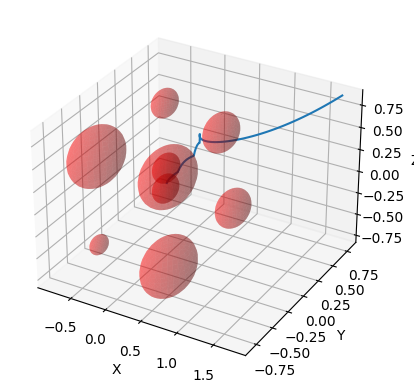

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')



ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

for i in range(len(obstacle_list)):
  plot_sphere(ax, obstacle_list[i].radius, obstacle_list[i].state)

ax.plot3D(quad_pos_state[:,0],quad_pos_state[:,1],quad_pos_state[:,2])
plt.show()